In [21]:
import torch
import config as config
import os
import sklearn as sk
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [22]:
# Load the data
train_df = pd.read_csv(config.TITANIC_DIR / 'train.csv')


In [23]:
# Map the data

def map(df):
    df = df.copy()
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Age'] = df['Age'].fillna(train_df['Age'].mean())            
    return df
    
train_df = map(train_df)

In [24]:
# Seperate input features
features = list(train_df.columns)
features.remove('Ticket')
features.remove('PassengerId')
features.remove('Name')
features.remove('SibSp')
features.remove('Embarked')
features.remove('Cabin')

# Engineer Features
train_df['Name_len'] = train_df['Name'].str.len()



# Convert to tensors
print(f"Input features: {features}")
X_train = train_df[features]
y_train = train_df['Survived']

# Scale and Split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
scaler.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)


Input features: ['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare']


In [25]:
# Hyperparameters

learning_rate = .02
total_epochs = 1000
batch_size = 400
dropout_probability = 0.3


In [26]:
X_train = torch.tensor(X_train.to_numpy(), dtype = torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype = torch.long)
X_test  = torch.tensor(X_test.to_numpy(), dtype = torch.float32)
y_test  = torch.tensor(y_test.to_numpy(), dtype = torch.long)

train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)



In [27]:
# Define the neural network model
class Titanicnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 128),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(128,64),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(64,16),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(16,8),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(8,2),
        )
    def forward(self, x):
        return self.net(x)
    
model = Titanicnet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

loss_array = []

In [28]:
# Training loop
def training_loop():
    last_avg = 0.0
    for epoch in range(1, total_epochs + 1):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            loss_array.append(loss.item())
        if epoch % 10 == 0:
            avg = epoch_loss / len(train_loader)
            if abs(last_avg-avg) <= 5e-3 and avg <= .05:    # Early stopping if loss is no longer improving
                print(f'difference is {abs(last_avg-avg)}')
                print(f"Early stopping at epoch {epoch:5d}")
                break
            print(f"Epoch {epoch:5d} — avg batch loss: {avg:.4f}")
            last_avg = avg
import cProfile
cProfile.run('training_loop()', sort= 'cumtime')


Epoch    10 — avg batch loss: 0.6283
Epoch    20 — avg batch loss: 0.5696
Epoch    30 — avg batch loss: 0.3028
Epoch    40 — avg batch loss: 0.1452
Epoch    50 — avg batch loss: 0.0969
Epoch    60 — avg batch loss: 0.1006
Epoch    70 — avg batch loss: 0.0900
Epoch    80 — avg batch loss: 0.0566
Epoch    90 — avg batch loss: 0.0515
Epoch   100 — avg batch loss: 0.0649
Epoch   110 — avg batch loss: 0.0596
Epoch   120 — avg batch loss: 0.0325
Epoch   130 — avg batch loss: 0.0589
Epoch   140 — avg batch loss: 0.0846
Epoch   150 — avg batch loss: 0.0817
Epoch   160 — avg batch loss: 0.0458
Epoch   170 — avg batch loss: 0.0399
Epoch   180 — avg batch loss: 0.1386
Epoch   190 — avg batch loss: 0.0610
Epoch   200 — avg batch loss: 0.0508
Epoch   210 — avg batch loss: 0.0520
Epoch   220 — avg batch loss: 0.0425
Epoch   230 — avg batch loss: 0.1347
Epoch   240 — avg batch loss: 0.0463
Epoch   250 — avg batch loss: 0.0550
Epoch   260 — avg batch loss: 0.1389
Epoch   270 — avg batch loss: 0.1118
E

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
model.eval()
with torch.no_grad():
    out = model(X_test)
    predicted_labels = torch.argmax(out, dim=1).flatten()
    true_labels = y_test

    # Calculate accuracy
    accuracy = (predicted_labels == true_labels).sum().item() / len(y_test) * 100
    print(f"Accuracy: {accuracy:.4f}%")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("\nClassification Report:")
    print(class_report)

Accuracy: 100.0000%
Confusion Matrix:
[[105   0]
 [  0  74]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        74

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



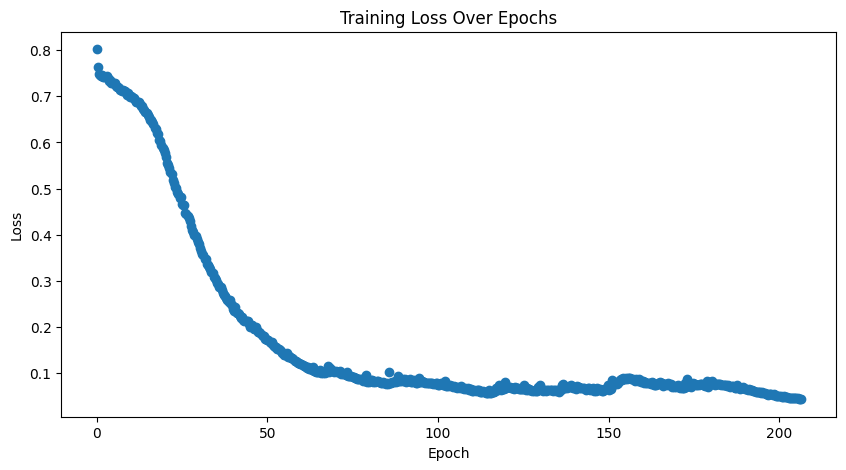

In [30]:
loss_array_epochs = [i/3 for i in range(len(loss_array))]
for i in range (len(loss_array)):
    loss_array[i] = np.mean(loss_array[max(0,i-9):i+1])

plt.figure(figsize = (10,5))
plt.plot(loss_array_epochs, loss_array, marker = 'o', linestyle = '')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(False)
plt.show()